# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50

from dataset import HWSet, HWSetMasks, normalize_inv

## Custom cmap

In [3]:
my_gradient = LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#4C71FF-0025B3-000000-C7030D-FC4A53
        (0.000, (0.298, 0.443, 1.000)),
        (0.250, (0.000, 0.145, 0.702)),
        (0.500, (0.000, 0.000, 0.000)),
        (0.750, (0.780, 0.012, 0.051)),
        (1.000, (0.988, 0.290, 0.325)),
    ),
)

# Dataset

In [4]:
data_dir = "../data"
split = "val"
class_legend = ("Siberian Husky", "Grey Wolf")

device = "cuda" if torch.cuda.is_available() else "cpu"

f"Using device: {device}"

'Using device: cuda'

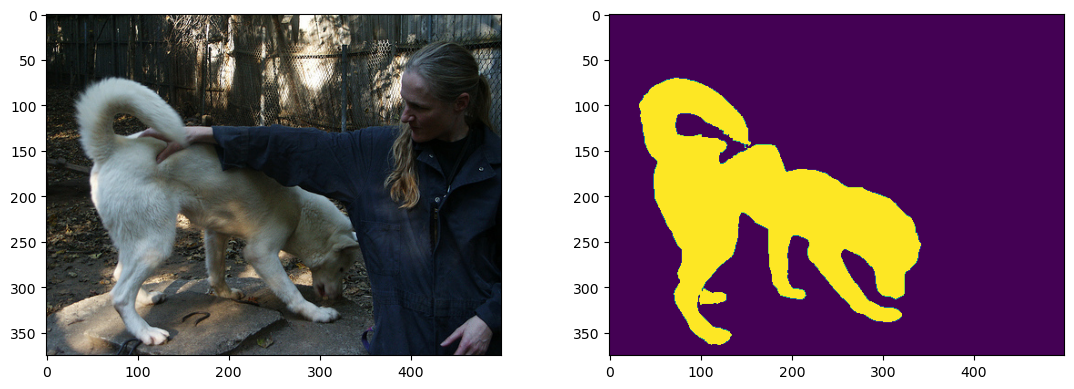

In [5]:
dset = HWSetMasks(data_dir, split)

im, label, mask = dset[0]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
ax0.imshow(im)
ax1.imshow(mask);

In [6]:
totensor = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]
)

transform_shared = transforms.Compose(
    [transforms.Resize(256, antialias=True), transforms.CenterCrop(224), totensor]
)

transform_img = transforms.Compose(
    [
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

dset = HWSetMasks(
    data_dir, split, transform_shared=transform_shared, transform_img=transform_img
)

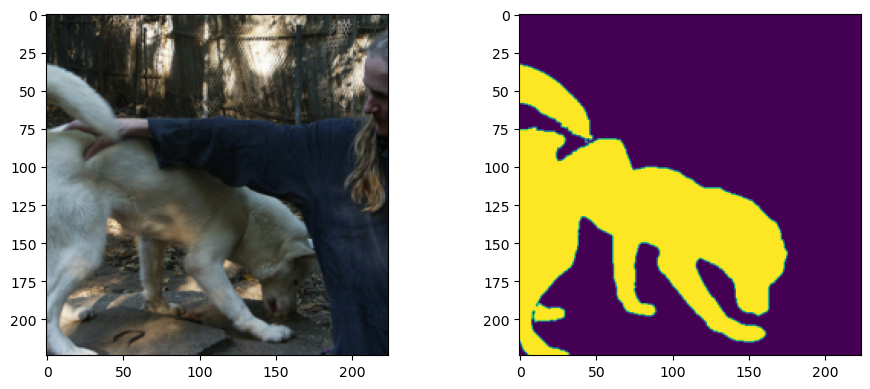

In [7]:
im, label, mask = dset[0]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
ax0.imshow(np.moveaxis(normalize_inv(im).numpy(), 0, -1))
ax1.imshow(np.moveaxis(mask.numpy(), 0, -1));

# Saliency for "use of context" quantification

In [8]:
model = resnet50(weights="IMAGENET1K_V2")
model.to(device)

dloader = DataLoader(dset, batch_size=1)

# Label to class map.
with open(f"{data_dir}/imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

In [9]:
def get_saliency(model, img_batch):
    # we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    # set model in eval mode
    model.eval()

    # we want to calculate gradient of higest score w.r.t. input
    # so set requires_grad to True for input
    img_batch.requires_grad = True

    # forward pass to calculate predictions
    preds = model(img_batch)
    score, indices = torch.max(preds, 1)

    # backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()

    # get max along channel axis
    slc = img_batch.grad[0].cpu()
    # slc, _ = torch.max(torch.abs(img_batch.grad[0].cpu()), dim=0)

    # #normalize to [-1..1]
    # slc = (slc - slc.min())/(slc.max()-slc.min())

    _, indices = torch.max(torch.abs(slc), dim=0)

    slc_new = torch.zeros(indices.size())
    
    for channel in range(slc.size()[0]):
        slc_new += slc[channel] * (indices == channel)

    slc_new /= slc_new.abs().max()
    slc = slc_new.numpy()

    return slc, score.cpu(), indices.cpu(), preds.cpu()

In [180]:
dloader_iter = iter(dloader)

Predicted (Top 5):	 ['Eskimo dog', 'Siberian husky', 'dogsled', 'malamute', 'German shepherd']
Confidence (Top 5):	 [26.18, 21.18, 0.55, 0.42, 0.33]
Ground truth:		 Siberian Husky


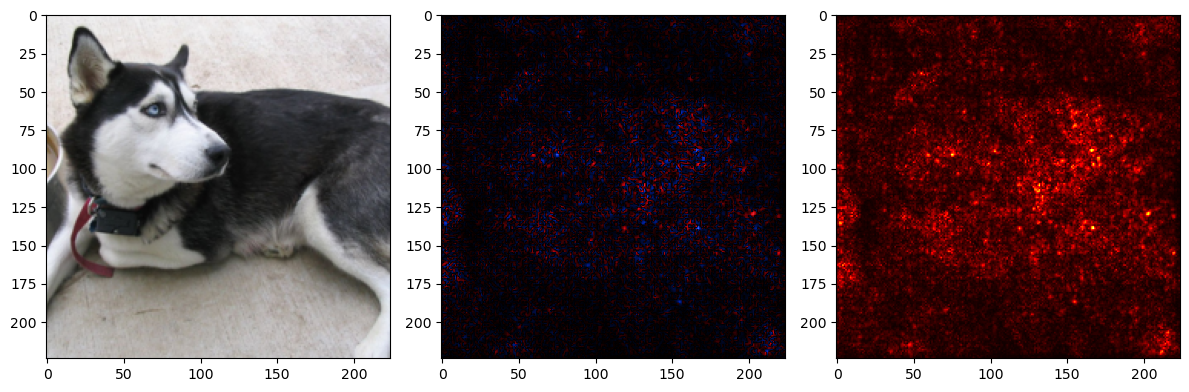

65.09%
62.50%


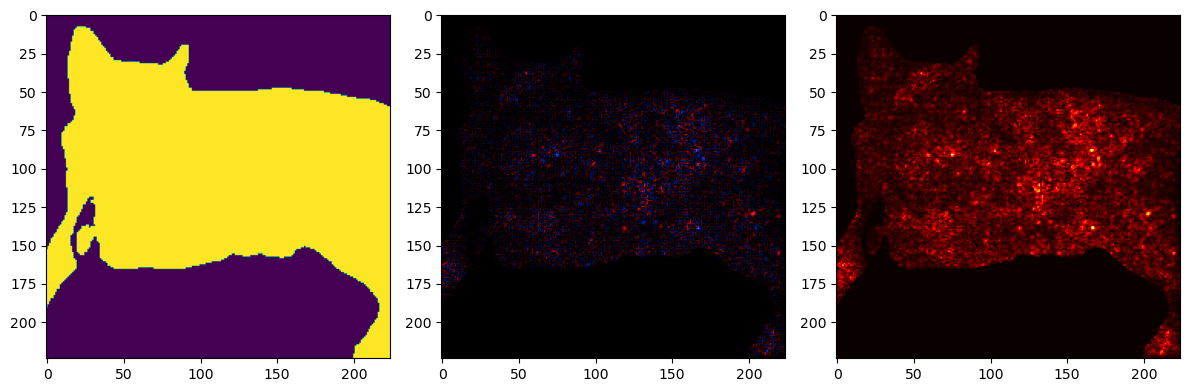

In [203]:
img_batch, label_batch, mask_batch = next(dloader_iter)

slc, score, indices, preds = get_saliency(model, img_batch.to(device))

topk = torch.topk(preds.flatten(), 5).indices
conf = torch.softmax(preds[0].cpu(), 0)
print(
    f"Predicted (Top 5):\t {[idx2label[idx.cpu().item()].split(', ')[0] for idx in topk]}\n" +
    f"Confidence (Top 5):\t {[round(conf[idx].item() * 100, 2) for idx in topk]}\n" +
    f"Ground truth:\t\t {class_legend[label_batch[0].item()]}" 
)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

ax0.imshow(np.moveaxis(normalize_inv(img_batch[0]).numpy(), 0, -1))
ax1.imshow((slc + 1) / 2, cmap=my_gradient, vmin=0, vmax=1)
ax2.imshow(np.abs(slc), cmap='hot', vmin=0, vmax=1)
plt.show()

mask = mask_batch[0, 0].numpy().astype(bool)

area = mask.shape[0] * mask.shape[1]
obj_area = mask.sum()

obj_frac = area / obj_area
bg_frac = area / (area - obj_area)

obj_score = np.abs(slc)[mask].sum() / np.abs(slc).sum()
print(f"{obj_score:.2%}")

obj_slc_score = np.abs(slc)[mask].sum()
obj_score = (obj_slc_score * obj_frac) / (obj_slc_score * obj_frac + (np.abs(slc).sum() - obj_slc_score) * bg_frac)
# obj_score = 1 / (1 + (np.abs(slc).sum() - obj_slc_score) * bg_frac / (obj_slc_score * obj_frac))
print(f"{obj_score:.2%}")
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

ax0.imshow(mask)
ax1.imshow(((slc * mask.astype(float) + 1) / 2) , cmap=my_gradient, vmin=0, vmax=1)
ax2.imshow(np.abs(slc) * mask.astype(float), cmap='hot', vmin=0, vmax=1)
plt.show()

In [130]:
area = mask.shape[0] * mask.shape[1]
obj_area = mask.sum()

obj_frac = area / obj_area
bg_frac = area / (area - obj_area)

obj_to_bg, mask.sum() * obj_frac * 0.5, (area - obj_area) * bg_frac * 0.5

(1.3758157389635317, 25088.0, 25088.0)